<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Wrangling" data-toc-modified-id="Data-Wrangling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Wrangling</a></span></li><li><span><a href="#Computing-p-values-for-gender-differences" data-toc-modified-id="Computing-p-values-for-gender-differences-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing p-values for gender differences</a></span></li><li><span><a href="#Computing-p-values-for-ADHD-subtypes-differences" data-toc-modified-id="Computing-p-values-for-ADHD-subtypes-differences-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Computing p-values for ADHD subtypes differences</a></span></li><li><span><a href="#General-scalp-plots" data-toc-modified-id="General-scalp-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>General scalp plots</a></span></li><li><span><a href="#Gender-differences-scalp-plots" data-toc-modified-id="Gender-differences-scalp-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Gender differences scalp plots</a></span></li><li><span><a href="#ADHD-subtype-differences-scalp-plots" data-toc-modified-id="ADHD-subtype-differences-scalp-plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ADHD subtype differences scalp plots</a></span></li></ul></div>

# Data Wrangling
This nootebooks is used to compute the p-values used in the Scalp_Plots_Pvals notebook. It should be transformed into a .py file and contain well organized functions.

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
import os
import preprocessing as pre
from sklearn import preprocessing
from statsmodels.sandbox.stats.multicomp import multipletests
import sklearn.metrics as metrics
#from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and organize eeg data
df_eeg = pre.process_all_excel_files()
df_eeg = df_eeg[(df_eeg.id != '10') & (df_eeg.id != '18') & (df_eeg.id != '52') & (df_eeg.id != '215') & (df_eeg.id != '617')]
df_eeg = df_eeg.sort_values(by=['id'])
#change dtype of id column from df
df_eeg['id']=df_eeg['id'].astype(int)

# load and organize neuropsy data
df_neuropsy = pd.read_excel("Neuropsy.xlsx", na_values=".")
df_neuropsy= df_neuropsy.dropna(axis=0, how='any')
df_neuropsy.rename(columns = {'ID':'id'}, inplace = True) #rename id so it can be merged

In [3]:
# Merge eeg and neuropsy dataframes and create subtype column
df_full = pd.merge(left=df_eeg, right=df_neuropsy, left_on='id', right_on='id')
df_full = df_full.sort_values(by=['id'])
df_full['subtype'] = df_full.apply(lambda x: pre.categorize_subtypes(x['inat'], x['hyper']), axis=1)
df_full

,electrode,brain_oscillation,fft_abs_power,freq_band,id,Age,Gender,cIM,cHR,cIE,cSC,inat,hyper,Aqtot,Aqaudi,Aqvis,RCQtot,RCQaudi,RCQvis,subtype
0,FP1,Delta,15.376173,1.0-4.0Hz,1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed
133,F7,Delta,7.968847,1.0-4.0Hz,1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed
134,F3,Delta,9.749313,1.0-4.0Hz,1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed
135,Fz,Delta,10.845292,1.0-4.0Hz,1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed
136,F4,Delta,10.679267,1.0-4.0Hz,1,21,1,17.0,31.0,29.0,9.0,18.0,20.0,90.0,91.0,92.0,94.0,80.0,110.0,mixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,C4,Gamma,1.198341,30.0-40.0Hz,702,18,1,17.0,14.0,10.0,9.0,12.0,3.0,91.0,88.0,95.0,94.0,87.0,104.0,inat
15959,C3,Beta2,2.209228,15.0-18.0Hz,702,18,1,17.0,14.0,10.0,9.0,12.0,3.0,91.0,88.0,95.0,94.0,87.0,104.0,inat
15960,Pz,Beta1,12.479250,12.0-15.0Hz,702,18,1,17.0,14.0,10.0,9.0,12.0,3.0,91.0,88.0,95.0,94.0,87.0,104.0,inat
15935,C4,Beta1,5.618459,12.0-15.0Hz,702,18,1,17.0,14.0,10.0,9.0,12.0,3.0,91.0,88.0,95.0,94.0,87.0,104.0,inat


In [4]:
#encoding the subtypes into numerocal labels for future SNF analysis/machine learning
# hyperactive = 0
# inattentive subtype = 1
# mixed subtype = 2
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df_full["adhdtype"] = lb_make.fit_transform(df_full["subtype"])
df_full[["subtype", "adhdtype"]].head(11)


,subtype,adhdtype
0,mixed,2
133,mixed,2
134,mixed,2
135,mixed,2
136,mixed,2
137,mixed,2
138,mixed,2
139,mixed,2
140,mixed,2
141,mixed,2


In [5]:
#Reorder columns 
df_full = df_full[['id','Gender','adhdtype', 'brain_oscillation','electrode','fft_abs_power']]
df_full['fft_abs_power'] = df_full['fft_abs_power'].astype(float)
df_analysis = df_full
df_analysis

,id,Gender,adhdtype,brain_oscillation,electrode,fft_abs_power
0,1,1,2,Delta,FP1,15.376173
133,1,1,2,Delta,F7,7.968847
134,1,1,2,Delta,F3,9.749313
135,1,1,2,Delta,Fz,10.845292
136,1,1,2,Delta,F4,10.679267
...,...,...,...,...,...,...
15958,702,1,1,Gamma,C4,1.198341
15959,702,1,1,Beta2,C3,2.209228
15960,702,1,1,Beta1,Pz,12.479250
15935,702,1,1,Beta1,C4,5.618459


# Computing p-values for gender differences 

Returns a csv file containing 76 p-values (corrected via bonferroni), to be used in the create_pval_mask functions used in topoplots functions.  

In [6]:
# Create separate dfs for men & women, according to brainwave
delta_women, delta_men = pre.createdf_by_gender('Delta', df_analysis)
theta_women, theta_men = pre.createdf_by_gender('Theta', df_analysis)
alpha_women, alpha_men = pre.createdf_by_gender('Alpha', df_analysis)
beta_women, beta_men = pre.createdf_by_gender('Beta', df_analysis)


In [7]:
# Pivot tables in order to get 1 column by electrode containing each participant's fft_abs_power 
# (separately for each gender & brainwave)
delta_women = pd.pivot_table(delta_women, values='fft_abs_power', index=['id'], columns=['electrode'])
delta_men = pd.pivot_table(delta_men, values='fft_abs_power', index=['id'], columns=['electrode'])
theta_women = pd.pivot_table(theta_women, values='fft_abs_power', index=['id'], columns=['electrode'])
theta_men = pd.pivot_table(theta_men, values='fft_abs_power', index=['id'], columns=['electrode'])
alpha_women = pd.pivot_table(alpha_women, values='fft_abs_power', index=['id'], columns=['electrode'])
alpha_men = pd.pivot_table(alpha_men, values='fft_abs_power', index=['id'], columns=['electrode'])
beta_women = pd.pivot_table(beta_women, values='fft_abs_power', index=['id'], columns=['electrode'])
beta_men = pd.pivot_table(beta_men, values='fft_abs_power', index=['id'], columns=['electrode'])


In [8]:
# Calling pre-defined function to compute electrodes p-values (corrected via bonferroni) from our preprocessing.py file
pvals = []
delta_pval = pre.mann_whitney(delta_women, delta_men, pvals)
theta_pval = pre.mann_whitney(theta_women, theta_men, pvals)
alpha_pval = pre.mann_whitney(alpha_women, alpha_men, pvals)
beta_pval = pre.mann_whitney(beta_women, beta_men, pvals)
#bonferroni conrrection & saving into a csv file
p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')
pvals_gender = p_adjusted[1]
pvals_gender = pd.DataFrame(pvals_gender)
pvals_gender.to_csv('Data/new_pvals_gender')  #we can save them into csv files just in case!
pvals_gender = np.asarray(pvals_gender) #the pvals need to be put into an array for future use

# Computing p-values for ADHD subtypes differences 

Returns a csv file containing 76 p-values (corrected via bonferroni), to be used in the create_pval_mask functions used in topoplots functions.  

In [9]:
# Create separate dfs for inattentive and mixed subtypes, according to brainwave
delta_inat, delta_mixed = pre.createdf_by_subtype('Delta', df_analysis)
theta_inat, theta_mixed = pre.createdf_by_subtype('Theta', df_analysis)
alpha_inat, alpha_mixed = pre.createdf_by_subtype('Alpha', df_analysis)
beta_inat, beta_mixed = pre.createdf_by_subtype('Beta', df_analysis)

In [10]:
# Pivot tables in order to get 1 column by electrode containing each participant's fft_abs_power 
# (separately for each gender & brainwave)
delta_inat = pd.pivot_table(delta_inat, values='fft_abs_power', index=['id'], columns=['electrode'])
delta_mixed = pd.pivot_table(delta_mixed, values='fft_abs_power', index=['id'], columns=['electrode'])
theta_inat = pd.pivot_table(theta_inat, values='fft_abs_power', index=['id'], columns=['electrode'])
theta_mixed = pd.pivot_table(theta_mixed, values='fft_abs_power', index=['id'], columns=['electrode'])
alpha_inat = pd.pivot_table(alpha_inat, values='fft_abs_power', index=['id'], columns=['electrode'])
alpha_mixed = pd.pivot_table(alpha_mixed, values='fft_abs_power', index=['id'], columns=['electrode'])
beta_inat = pd.pivot_table(beta_inat, values='fft_abs_power', index=['id'], columns=['electrode'])
beta_mixed = pd.pivot_table(beta_mixed, values='fft_abs_power', index=['id'], columns=['electrode'])


In [11]:
# Calling pre-defined function to compute electrodes p-values (corrected via bonferroni) from our preprocessing.py file
pvals = []
delta_pval = pre.mann_whitney(delta_inat, delta_mixed, pvals)
theta_pval = pre.mann_whitney(theta_inat, theta_mixed, pvals)
alpha_pval = pre.mann_whitney(alpha_inat, delta_mixed, pvals)
beta_pval = pre.mann_whitney(beta_inat, beta_mixed, pvals)
#bonferroni conrrection & saving into a csv file
p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')
pvals_subtype = p_adjusted[1]
pvals_subtype = pd.DataFrame(pvals_subtype)
pvals_subtype.to_csv('Data/new_pvals_subtype') #we can save them into csv files just in case!
pvals_subtype = np.asarray(pvals_subtype) #the pvals need to be put into an array for future use

# General scalp plots

In [12]:
df_eeg = pd.read_csv('Data/df_eeg_topo', index_col=[0])
df_eeg


,id,Gender,adhdtype,brain_oscillation,electrode,fft_abs_power,brain_oscillation_num,electrode_num,electrode_pool
0,1,1,2,Delta,FP1,15.376173,6,7,frontal
133,1,1,2,Delta,F7,7.968847,6,5,frontal
134,1,1,2,Delta,F3,9.749313,6,3,frontal
135,1,1,2,Delta,Fz,10.845292,6,9,frontal
136,1,1,2,Delta,F4,10.679267,6,4,frontal
...,...,...,...,...,...,...,...,...,...
15957,702,1,1,Beta2,O1,3.126227,5,10,occipital
15959,702,1,1,Beta2,C3,2.209228,5,0,central
15960,702,1,1,Beta1,Pz,12.479250,4,14,parietal
15935,702,1,1,Beta1,C4,5.618459,4,1,central


In [13]:
#First, separate general signal by brainwave
alpha = df_eeg.loc[df_eeg['brain_oscillation'] == 'Alpha']
alpha = alpha[['electrode','fft_abs_power']]
beta = df_eeg.loc[df_eeg['brain_oscillation'] == 'Beta']
beta = beta[['electrode','fft_abs_power']]
delta = df_eeg.loc[df_eeg['brain_oscillation'] == 'Delta']
delta = delta[['electrode','fft_abs_power']]
theta = df_eeg.loc[df_eeg['brain_oscillation'] == 'Theta']
theta = theta[['electrode','fft_abs_power']]
theta

,electrode,fft_abs_power
150,FP1,3.890395
151,FP2,3.813533
152,F7,2.377164
153,F3,3.845777
154,Fz,4.259641
...,...,...
16001,O2,8.924826
16013,F4,12.414647
16015,F3,12.058871
15990,C3,10.565776


In [14]:
# We need to compute the mean absolute power for each electrode.
avg_abspow_by_electro_alpha = alpha.groupby('electrode')['fft_abs_power'].agg('mean')
avg_abspow_by_electro_beta = beta.groupby('electrode')['fft_abs_power'].agg('mean')
avg_abspow_by_electro_delta = delta.groupby('electrode')['fft_abs_power'].agg('mean')
avg_abspow_by_electro_theta = theta.groupby('electrode')['fft_abs_power'].agg('mean')

# The data we will need for create our topoplots are the mean fft absolute power for each electrode.
# the mean amplitude were computed in a previous section for graph plots of each electrodes amplitude
# There will be one topoplot for each frequency band. They will need to be called as toplot in the plotting function.
mean_alpha = np.asarray(avg_abspow_by_electro_alpha)
mean_beta = np.asarray(avg_abspow_by_electro_beta)
mean_delta = np.asarray(avg_abspow_by_electro_delta)
mean_theta = np.asarray(avg_abspow_by_electro_theta)
data = [mean_delta, mean_theta, mean_alpha, mean_beta]

In [15]:
#corresponding electrodes in order are: C3, C4, Cz, F3, F4, F7, F8, FP1, FP2, Fz, O1, O2, P3, P4, Pz, T3, T4, T5, T6
ch_xy = np.array([[-2, 0], [2, 0], [0, 0], [-2, 2], [2, 2], [-4, 2], [4, 2], [-2, 4], [2, 4], [0, 2], [-2, -4], [2, -4], [-2, -2], [2, -2], [0, -2], [-4, 0], [4, 0], [-4, -2], [4, -2]])

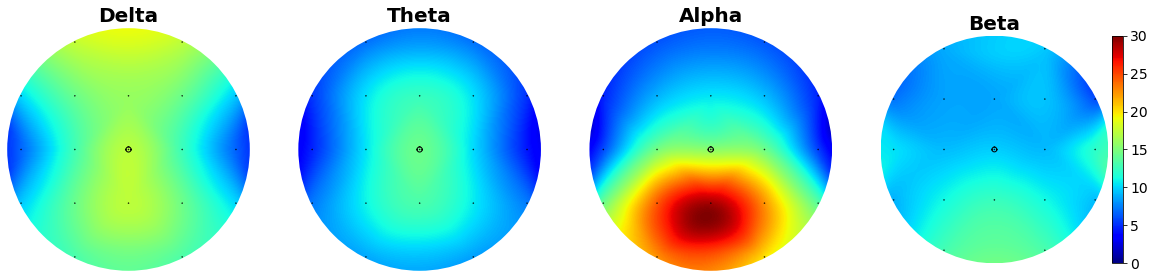

In [16]:
general = pre.array_topoplot(data, ch_xy); # ";" needed in notebook so it doesn't print in double, maybe remove if on other ide

# Gender differences scalp plots


In [17]:
# Create separate dfs for men & women, according to brainwave
delta_women, delta_men = pre.createdf_by_gender('Delta', df_eeg)
theta_women, theta_men = pre.createdf_by_gender('Theta', df_eeg)
alpha_women, alpha_men = pre.createdf_by_gender('Alpha', df_eeg)
beta_women, beta_men = pre.createdf_by_gender('Beta', df_eeg)

In [18]:
# prep_eeg_data function selects pertinent columns (here, 'electrode' and 'fft_abs_power')
# and then averages fft_avg_power across all the different electrodes
avg_delta_women = pre.prep_eeg_data(delta_women)
avg_delta_men = pre.prep_eeg_data(delta_men)
avg_theta_women = pre.prep_eeg_data(theta_women)
avg_theta_men = pre.prep_eeg_data(theta_men)
avg_alpha_women = pre.prep_eeg_data(alpha_women)
avg_alpha_men = pre.prep_eeg_data(alpha_men)
avg_beta_women = pre.prep_eeg_data(beta_women)
avg_beta_men = pre.prep_eeg_data(beta_men)

women_eeg = [avg_delta_women, avg_theta_women, avg_alpha_women, avg_beta_women]
men_eeg = [avg_delta_men, avg_theta_men, avg_alpha_men, avg_beta_men]

In [19]:
# Now, we compute the difference between our groups (A - B/B)
subtract_gender=np.subtract(women_eeg, men_eeg) # substract gender 2 from gender 1 (women - men)
divide_gender=np.true_divide(subtract_gender, men_eeg) # divide substraction result by gender 2 so they're on same scale


In [20]:
# In order to quickly visualize where the actual differences are, we computed the p-values of the gender 
# differences across all electrodes. We can load the pvals and put them into an array.
# new_gender_pvals = pd.read_csv('Data/new_gender_pvals', index_col=[0])
# new_gender_pvals = np.asarray(new_gender_pvals)
# pvals_gender = np.asarray(pvals_gender)

In [21]:
mask = pre.create_pval_mask(pvals_gender, alpha=0.05)
mask = np.split(mask, 4)
mask

[array([False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True, False,
        False]),
 array([False, False,  True, False, False, False, False, False, False,
         True, False, False, False, False, False,  True,  True, False,
        False]),
 array([False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False]),
 array([False, False, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False, False,  True, False, False,
        False])]

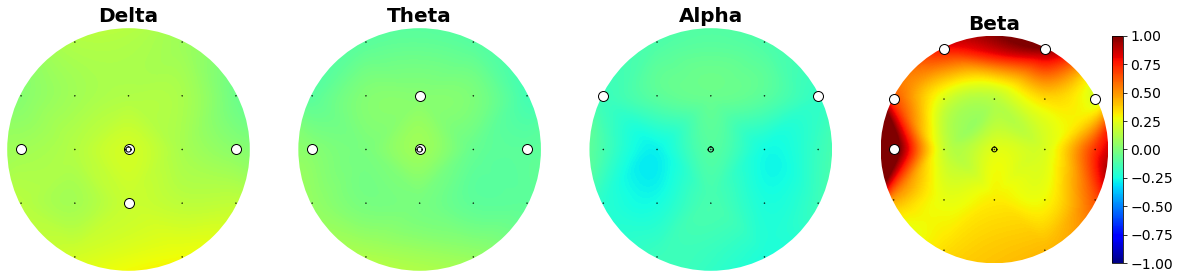

In [22]:
gender_plot = pre.array_topoplot(divide_gender, ch_xy, vmin = -1, vmax = 1, with_mask = True, masks = mask);

As we can see, there are a few differences between genders, mainly in the beta waveband.

# ADHD subtype differences scalp plots

In [23]:
# Create separate dfs for inattentive and combined (mixed) subtypes, according to brainwave
delta_inat, delta_mixed = pre.createdf_by_subtype('Delta', df_eeg)
theta_inat, theta_mixed = pre.createdf_by_subtype('Theta', df_eeg)
alpha_inat, alpha_mixed = pre.createdf_by_subtype('Alpha', df_eeg)
beta_inat, beta_mixed = pre.createdf_by_subtype('Beta', df_eeg)

In [24]:
# prep_eeg_data function selects pertinent columns (here, 'electrode' and 'fft_abs_power')
# and then averages fft_avg_power across all the different electrodes
avg_delta_inat = pre.prep_eeg_data(delta_inat)
avg_delta_mixed = pre.prep_eeg_data(delta_mixed)
avg_theta_inat = pre.prep_eeg_data(theta_inat)
avg_theta_mixed = pre.prep_eeg_data(theta_mixed)
avg_alpha_inat = pre.prep_eeg_data(alpha_inat)
avg_alpha_mixed = pre.prep_eeg_data(alpha_mixed)
avg_beta_inat = pre.prep_eeg_data(beta_inat)
avg_beta_mixed = pre.prep_eeg_data(beta_mixed)

inat_eeg = [avg_delta_inat, avg_theta_inat, avg_alpha_inat, avg_beta_inat]
mixed_eeg = [avg_delta_mixed, avg_theta_mixed, avg_alpha_mixed, avg_beta_mixed]

In [25]:
# Now, we compute the difference between our groups (A - B/B)
subtract_subtype=np.subtract(inat_eeg, mixed_eeg) # substract gender 2 from gender 1 (women - men)
divide_subtype=np.true_divide(subtract_subtype, mixed_eeg) # divide substraction result by gender 2 so they're on same scale

In [26]:
mask = pre.create_pval_mask(pvals_subtype, alpha=0.05)
mask = np.split(mask, 4)
mask

[array([ True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False]),
 array([ True,  True,  True,  True,  True, False, False, False, False,
         True, False, False,  True,  True,  True, False, False, False,
        False]),
 array([ True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False]),
 array([False, False,  True, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True, False, False, False,
        False])]

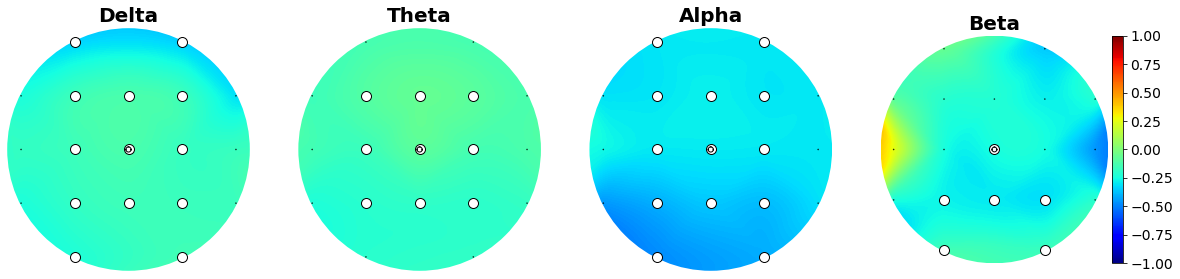

In [27]:
subtype_plot = pre.array_topoplot(divide_subtype, ch_xy, vmin = -1, vmax = 1, with_mask = True, masks = mask);

As we can see, most electrodes are different across ADHD subtype, except for temporal electrodes. 